In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import sagemaker
session = sagemaker.Session()
from sagemaker.tuner import ContinuousParameter as cp
from sagemaker.tuner import IntegerParameter as ip
from sagemaker.tuner import HyperparameterTuner

In [112]:
df = pd.read_csv("s3://fraudcredit-dataset/data/train.csv")

## Data Discovery

- Time is the time of any transaction from first transaction
- V1-V28 are features obtained after PCA, so exact knowlwdge of these features are not known.
- Amount is amount pertaining to each transation
- Class depicts the fraud mark, if its 0 then its a non frauduelent transaction else fraudulent.

In [35]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- NA values Check

In [37]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

- We can see that class is highly imbalanced, hence we need to balance it with either oversampling or undersampling

In [4]:
df['Class'].value_counts()

0    226581
1       417
Name: Class, dtype: int64

- Plot of Time Vs Amount, We can see fraud transactions occurred with lower amounts, mostly lesser than 2500.

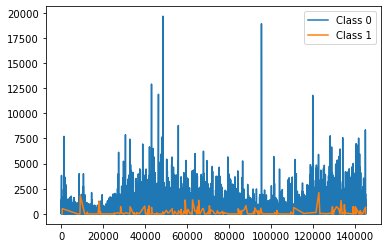

In [55]:
plt.plot(df.loc[df['Class'] == 0, 'Time'], df.loc[df['Class'] == 0, 'Amount'],label = 'Class 0')
plt.plot(df.loc[df['Class'] == 1, 'Time'], df.loc[df['Class'] == 1, 'Amount'],label = 'Class 1')
plt.legend()

- Mean amount in fraud class is higher

In [69]:
df[['Class','Amount']].groupby(['Class']).mean()

,Amount
Class,
0,90.782605
1,125.656379


- Lets see the distribution of amount with class

(0.0, 2000.0)

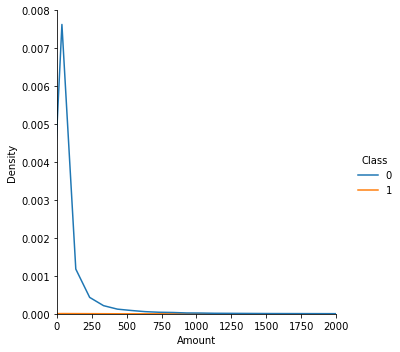

In [61]:
sns.displot(df, x="Amount", hue="Class", kind="kde")
plt.xlim(0, 2000)

- Let's see class label 1 seperately
- We can see that more or less fraud transactions are between 0-1000 with mean of ~120

(0.0, 2000.0)

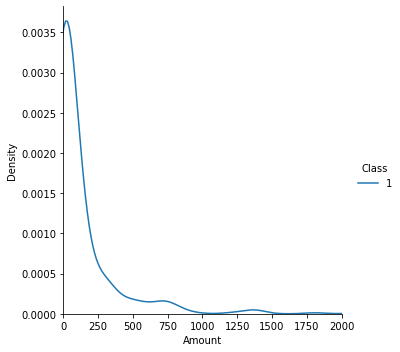

In [64]:
sns.displot(df.loc[df['Class'] == 1], x="Amount", hue="Class", kind="kde")
plt.xlim(0, 2000)

In [234]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226993,144892.0,2.025408,-0.182197,-3.124741,-0.351013,2.606837,3.283100,-0.567525,0.834910,0.678313,...,-0.037280,0.099739,0.080699,0.631398,0.127218,0.660080,-0.021093,-0.037461,1.00,0
226994,144892.0,2.121869,-1.316519,-0.760738,-1.053932,-0.918447,0.342454,-1.398621,0.273090,0.358644,...,0.404450,1.102384,0.031410,0.096616,-0.095076,-0.000199,-0.004976,-0.057101,32.79,0
226995,144893.0,2.029820,-0.089251,-1.384575,0.501001,-0.023316,-0.654838,-0.311700,-0.015501,1.014736,...,-0.092163,-0.174977,0.248592,0.560063,-0.271976,0.421233,-0.042939,-0.024141,2.99,0
226996,144893.0,-1.229480,3.273274,-1.887468,4.860818,-0.068843,-0.493099,-0.271717,1.065829,-1.263195,...,-0.406868,-1.157435,0.325132,-0.377445,-0.592161,0.020644,-0.197684,-0.154466,6.03,0


In [247]:
l1 = [[x+i for x in list(df.loc[(df['Class'] == 1) & (df['Amount'] != 0)].index)] for i in range(0,6)]

In [255]:
fraud_list = list(df.loc[(df['Class'] == 1) & (df['Amount'] != 0)].index)

In [251]:
l2 = sorted(set([item for sublist in l1 for item in sublist]))

In [256]:
list_nearby_transaction = [i for i in l2 if i not in fraud_list]

In [258]:
df_vicinity = df.loc[list_nearby_transaction]

## Vicinity Plot

- We can see that Vicinity Transactions i.e Transactions in a window of 0-5 Transactions up and down from Fraduelent one's are of higher Amounts, we can see that Peaks got isolated in Normal Vicinity Transacations from Overall transactions 

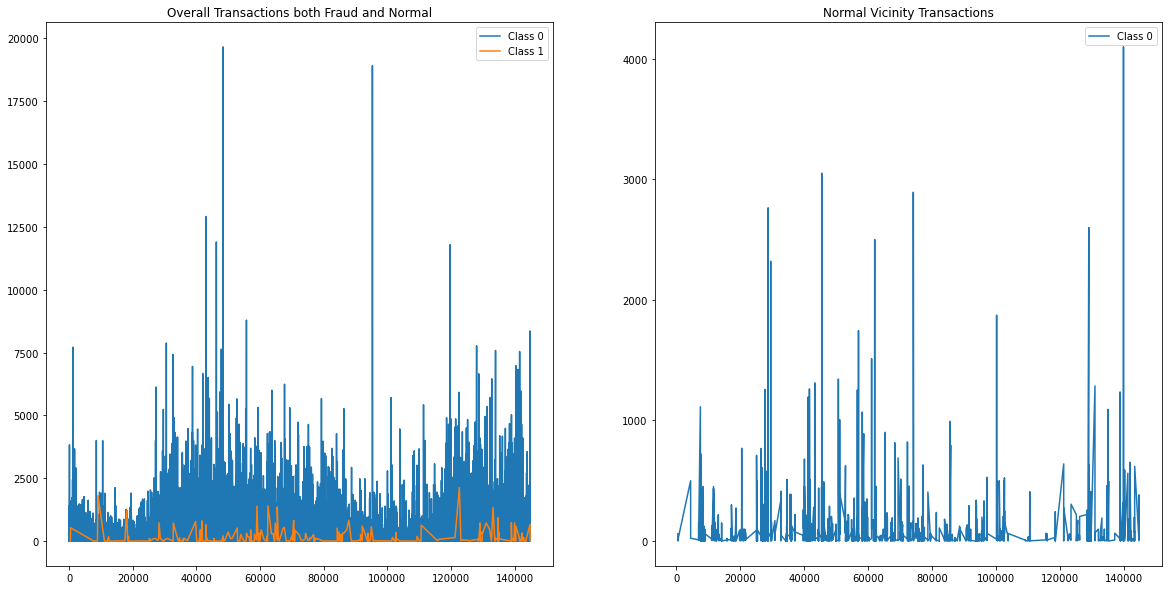

In [272]:
plt.figure(figsize = (20,10))
plt.subplot(1, 2, 1)
plt.plot(df.loc[df['Class'] == 0, 'Time'], df.loc[df['Class'] == 0, 'Amount'],label = 'Class 0')
plt.plot(df.loc[df['Class'] == 1, 'Time'], df.loc[df['Class'] == 1, 'Amount'],label = 'Class 1')
plt.title("Overall Transactions both Fraud and Normal")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(df_vicinity.loc[df['Class'] == 0, 'Time'], df_vicinity.loc[df_vicinity['Class'] == 0, 'Amount'],label = 'Class 0')
plt.title("Normal Vicinity Transactions")
plt.legend()

- Class variable has negative correlation with many features, while there is less correlation amongst independent variables. As V1-V28 are created by PCA, there linear dependency is very less.

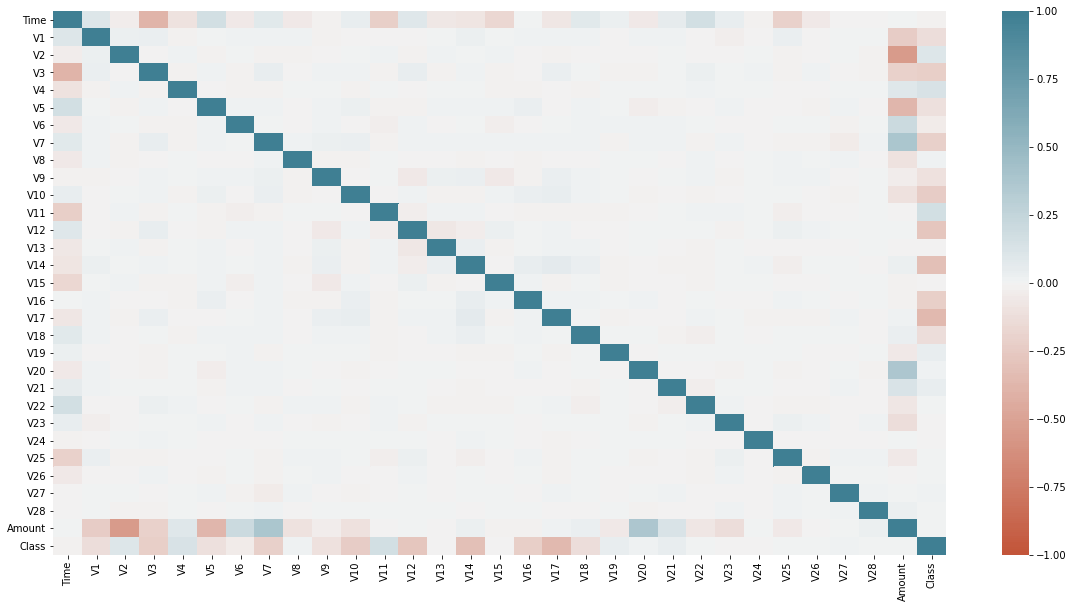

In [42]:
plt.figure(figsize = (20,10))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200)
)

# Data Preparation

In [123]:
prefix = "data_prep"
bucket = "fraudcredit-dataset"

In [114]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [115]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X, y ,test_size = 0.2, shuffle=False)

In [118]:
pd.concat([y_train,x_train],axis = 1).to_csv("train1.csv",header = False,index = False)

In [119]:
pd.concat([y_valid,x_valid],axis = 1).to_csv("valid1.csv",header = False,index = False)

In [121]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,"train/train.csv")).upload_file("train1.csv")
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,"valid/valid.csv")).upload_file("valid1.csv")

# Modelling

In [122]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='latest')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [127]:
s3_train_data = sagemaker.session.s3_input(s3_data = 's3://{}/{}/train'.format(bucket, prefix),content_type = 'csv')
s3_validation_data = sagemaker.session.s3_input(s3_data = 's3://{}/{}/valid'.format(bucket, prefix),content_type = 'csv')

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [129]:
session

In [187]:
xgb_model = sagemaker.estimator.Estimator(container,
                                    role=get_execution_role(),
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session
                                    )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [188]:
xgb_model.set_hyperparameters(
    max_depth = 5,
    subsample = 0.8,
    num_round = 50,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    objective = 'binary:logistic',
    eval_metric = 'auc'
)

In [189]:
xgb_model.fit({'train':s3_train_data,'validation':s3_validation_data})

2021-12-03 13:41:26 Starting - Starting the training job...
2021-12-03 13:41:49 Starting - Launching requested ML instancesProfilerReport-1638538886: InProgress
...
2021-12-03 13:42:19 Starting - Preparing the instances for training.........
2021-12-03 13:43:54 Downloading - Downloading input data...
2021-12-03 13:44:27 Training - Training image download completed. Training in progress..Arguments: train
[2021-12-03:13:44:28:INFO] Running standalone xgboost training.
[2021-12-03:13:44:28:INFO] File size need to be processed in the node: 90.49mb. Available memory size in the node: 8344.48mb
[2021-12-03:13:44:28:INFO] Determined delimiter of CSV input is ','
[13:44:28] S3DistributionType set as FullyReplicated
[13:44:28] 181598x30 matrix with 5447940 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-12-03:13:44:28:INFO] Determined delimiter of CSV input is ','
[13:44:28] S3DistributionType set as FullyReplicated
[13:44:28] 45400x30 matrix with 136200

In [192]:
predictor = xgb_model.deploy(initial_instance_count=1,
                       model_name="{}-xgb".format('FraudModelXgb'),
                       endpoint_name="{}-xgb".format('FraudModelEndPointXgb'),
                       instance_type='ml.m4.xlarge')

Using already existing model: FraudModelXgb-xgb


------!

In [193]:
predictor.serializer = sagemaker.serializers.CSVSerializer()

In [194]:
test = pd.read_csv("s3://fraudcredit-dataset/data/test.csv")

In [195]:
test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,144893,2.057496,0.076345,-1.893408,0.179545,0.734665,-0.191632,0.049654,-0.025251,0.284664,...,-0.340743,-0.909377,0.274296,-0.066170,-0.241510,0.190313,-0.064810,-0.046415,1.98,0
1,144893,1.744125,-0.493494,-0.635908,1.333290,0.345852,1.624104,-0.571394,0.568925,1.323268,...,-0.439836,-1.024800,0.536912,-0.460976,-0.569911,-1.037838,0.089253,-0.031597,42.98,0
2,144894,-0.758391,1.143454,-0.798124,-0.333880,2.465843,-0.961544,1.586615,-0.278394,-0.580092,...,0.066881,0.191850,-0.363299,0.149835,0.400646,-0.771319,-0.031268,0.272797,1.00,0
3,144894,2.088701,-1.187320,-0.381122,-0.554617,-1.080683,0.313513,-1.359061,0.182925,0.479556,...,-0.397774,-0.671753,0.347479,0.039015,-0.644204,0.469529,-0.006034,-0.030361,38.99,0
4,144894,-1.108486,0.810326,-0.865200,-0.848797,1.961462,-0.346329,1.457932,0.075183,-0.554697,...,0.448833,1.455308,-0.698171,-0.977931,0.733008,-0.135713,-0.258377,-0.291331,16.48,0


In [196]:
def predict(predictor,data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [197]:
preds = predict(predictor,test.drop(['Class'],axis  = 1).to_numpy())

In [198]:
preds

array([1.15255491e-04, 2.13810068e-04, 2.98936968e-04, ...,
       1.35810944e-04, 8.58901767e-05, 1.06620639e-04])

In [212]:
from sklearn.metrics import roc_auc_score
print("Training AUC", roc_auc_score( test['Class'],  np.round(preds))) 

Training AUC 0.8466406854424314


In [199]:
pd.crosstab(index = test['Class'],columns = np.round(preds),rownames = ['Actual'],colnames = ['Prediction'])

Prediction,0.0,1.0
Actual,,
0,57731,3
1,23,52


## Grid Search using Sagemaker Auto Tuner

In [225]:
hyper_params = {"alpha": cp(0.01, 10, scaling_type="Logarithmic"),
                "max_depth": ip(3, 10, scaling_type="Linear"),
                "lambda": cp(0.01, 10, scaling_type="Logarithmic"),
                "subsample" : cp(0.6, 0.9, scaling_type="Linear"),
                "num_round" : ip(25, 100, scaling_type="Linear"),
                "eta" : cp(0.1, 0.3, scaling_type="Linear"),
                "gamma" : ip(2, 8, scaling_type="Linear"),
                "min_child_weight" : ip(2, 8, scaling_type="Linear"),
}

In [226]:
auto_tuner = HyperparameterTuner(
    xgb_model,
    hyperparameter_ranges = hyper_params,
    objective_metric_name = "validation:auc",
    max_jobs=5,
    max_parallel_jobs=4,
    strategy="Random"
)

In [227]:
auto_tuner.fit({"train": s3_train_data, "validation": s3_validation_data})

..........................................................................................................!


In [228]:
predictor_tuner = auto_tuner.deploy(initial_instance_count=1,
                       model_name="{}-xgb".format('FraudModelXgbAutoTuner1'),
                       endpoint_name="{}-xgb".format('FraudModelEndPointXgbAutoTuner'),
                       instance_type='ml.m4.xlarge')


2021-12-03 14:33:58 Starting - Preparing the instances for training
2021-12-03 14:33:58 Downloading - Downloading input data
2021-12-03 14:33:58 Training - Training image download completed. Training in progress.
2021-12-03 14:33:58 Uploading - Uploading generated training model
2021-12-03 14:33:58 Completed - Training job completed


Using already existing model: FraudModelXgbAutoTuner1-xgb


-----!

In [229]:
predictor_tuner.serializer = sagemaker.serializers.CSVSerializer()

In [230]:
preds1 = predict(predictor_tuner,test.drop(['Class'],axis  = 1).to_numpy())

In [231]:
preds1

array([1.55056128e-04, 2.25844240e-04, 1.47602957e-04, ...,
       1.13480506e-04, 8.59726133e-05, 9.34234704e-05])

In [232]:
from sklearn.metrics import roc_auc_score
print("Training AUC", roc_auc_score( test['Class'],  np.round(preds1)))

Training AUC 0.8332727104767843


In [233]:
pd.crosstab(index = test['Class'],columns = np.round(preds1),rownames = ['Actual'],colnames = ['Prediction'])

Prediction,0.0,1.0
Actual,,
0,57727,7
1,25,50


# According to Crosstab and AUC score our XGB Basic model outporfming Autotuner Model

In [204]:

'''
#DON'T RUN THIS
'''


import sagemaker

sagemaker.Session().delete_endpoint(predictor_tuner.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-2:746012564509:endpoint/fraudmodelendpointxgbautotuner-xgb".